In [90]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
from collections import defaultdict
import ml_collections
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import matplotlib
import matplotlib.pyplot as plt

import torch as ch
import seaborn as sns
from scipy.stats import linregress

%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_style('whitegrid')

repo_path = Path.cwd() / 'repos_xfs' / 'apple-moe' / 'src'
sys.path.append(str(repo_path))
from l3m.helpers import utils_misc
from l3m.helpers import utils_scaling_law
from l3m.helpers import utils_notebook
from l3m.helpers import utils_polyfit

import plotly.io as pio
pio.renderers.default = 'notebook_connected'

import plotly.graph_objects as go
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

plt.rcParams.update({
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': .5,
    'ytick.major.size': .5,
    'xtick.major.width': .5,
    'ytick.major.width': .5,
    'xtick.color': 'k',
    'ytick.color': 'k',
    'axes.edgecolor': 'black'
})
sns.set_style('ticks')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
import re
import turibolt as bolt

pattern = re.compile(r'^checkpoint(_(\d+))?\.pth$')

def extract_number(file):
    match = pattern.match(file)
    if match:
        number = match.group(2)
        return int(number) if number else 0
    return 0
    
def filter_function(run):
    try:
        bolt_task_id =  run.metadata["host"].split('-')[1]
        max_iterations = run.config['experiment']['total_iterations']
        files = []
        task = bolt.get_task(bolt_task_id)
        files = list(task.artifacts.list())
        files = [file for file in files if pattern.match(file)]
        # print(files)
        files = sorted(files, key=extract_number)
        final_checkpoint = files[-1]
        last_checkpoint_iterations = extract_number(files[-1])
        if max_iterations == last_checkpoint_iterations:
            print(run.id, bolt_task_id, 'complete')
            return True
    except Exception as e:
        print(run.state)
        try:
            print(bolt_task_id, max_iterations, files)
        except:
            pass
        print(e)

    return False


In [5]:
# wandb_project_map = {
#     'sparsity0.00 (dense)': 'mlr_l3m/LLMScalingLaws_MoE_sparsity0',
#     'sparsity0.25': 'mlr_l3m/LLMScalingLaws_MoE_sparsity0.25',
#     'sparsity0.50': 'mlr_l3m/LLMScalingLaws_MoE_sparsity0.50', 
#     'sparsity0.75': 'mlr_l3m/LLMScalingLaws_MoE_sparsity0.75',
#     'sparsity0.90': 'mlr_l3m/LLMScalingLaws_MoE_sparsity0.90',
#     'sparsity0.95': 'mlr_l3m/LLMScalingLaws_MoE_sparsity0.95',
#     'sparsity0.98': 'mlr_l3m/LLMScalingLaws_MoE_sparsity0.98'
# }





# frames = {pname: utils_notebook.get_runs_dataframe('../.wandb.yaml', wandb_project_map[pname],  
#                                                    filter_func=filter_function,
#                                                    states=['finished', 'Failed'], #, 'running', 'crashed'], 
#                                                    count_router_parameters=False) for pname in wandb_project_map}


In [92]:
NOTEBOOKS_DIR = Path.cwd()
FLOPS = 3e20
FLOPS_STR = '3e20'

title_fs = 14
label_fs = 13
legend_fs = 12
ticks_fs = 11

In [94]:
df = pd.read_csv('valid_wand_logs_latest')

df = df[~df['metadata.wandb_id'].isin(['k8iozpan'])]

df['ffn_target.granularity'] = df['ffn_target.granularity'].replace(np.nan, 1)
df['ffn_target.expansion_factor'] = df['ffn_target.expansion_factor'].fillna(df['ffn_target.num_experts'])
df['ffn_target.num_experts'] = df['ffn_target.num_experts'].fillna(df['ffn_target.expansion_factor'] * df['ffn_target.granularity'])
df['sparsity'] = - np.log(1 - (1.0 - (df['ffn_target.top_k'] / df['ffn_target.num_experts'])))


In [95]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

df = df.sort_values('summary._step').groupby('metadata.bolt_id').last()
# df.to_csv(f'valid_wand_logs_{current_time}')

In [96]:
def generate_polynomial_matrix(N, S, degree_N=2, degree_S=2, degree_NS=2):
    """
    Generate a polynomial matrix for the given N, S, and degrees for N, S, and NS interaction.
    """
    poly_N = PolynomialFeatures(degree=degree_N, include_bias=False)
    poly_S = PolynomialFeatures(degree=degree_S, include_bias=False)
    poly_NS = PolynomialFeatures(degree=degree_NS, include_bias=False)

    N_poly = poly_N.fit_transform(N.reshape(-1, 1)) if degree_N > 0 else np.ones((len(N), 1))
    S_poly = poly_S.fit_transform(S.reshape(-1, 1)) if degree_S > 0 else np.ones((len(S), 1))
    NS_interaction = poly_NS.fit_transform((N * S).reshape(-1, 1)) if degree_NS > 0 else np.ones((len(N), 1))

    X_poly = np.hstack([N_poly, S_poly, NS_interaction])
    return X_poly

def get_train_test_split(X, Y, test_size):
    """
    Get a train-test split for the given data.
    """
    if test_size == 0.0:
        return {
            'train_inds': np.arange(len(X)),
            'test_inds': np.arange(len(X)),
            'train': (X, Y),
            'test': (X, Y)
        }

    inds = np.arange(len(X))
    np.random.shuffle(inds)
    num_train = int((1-test_size)*len(inds))
    train_inds = inds[:num_train]
    test_inds = inds[num_train:]
    X_train, X_test, Y_train, Y_test = X[train_inds], X[test_inds], Y[train_inds], Y[test_inds]

    return {
        'train_inds': train_inds,
        'test_inds': test_inds,
        'train': (X_train, Y_train),
        'test': (X_test, Y_test)
    }

def get_basic_data(all_df, flops, loss_col='loss.val_final', N_col='num_params.wo_embed', S_col='sparsity'):
    # get best model for each (N, S)
    df = all_df[all_df['flops.logged']==flops].copy()
    df = df.sort_values('loss.val_final').groupby([N_col, S_col]).first().reset_index()

    # get N, S, L
    N = df[N_col].values
    N = np.log(N)
    L = df[loss_col].values
    S = df[S_col].values

    return N, S, L

def fit_polynomial_model(N, S, L, degree_N, degree_S, degree_NS, test_size):
    """
    - split into train and test
    - fit polynomial model
    - eval on test
    - return everything
    """
    X_poly = generate_polynomial_matrix(N, S, degree_N=degree_N, degree_S=degree_S, degree_NS=degree_NS)

    train_test = get_train_test_split(X_poly, L, test_size=test_size)

    model = LinearRegression()
    model.fit(*train_test['train'])
    test_pred = model.predict(train_test['test'][0])

    return {
        'model': model,
        'train_data': train_test['train'],
        'test_data': train_test['test'],
        'test_gt': train_test['test'][1],
        'test_pred': test_pred,
        'test_sparsity': S[train_test['test_inds']],
        'test_mse': np.mean((test_pred - train_test['test'][1])**2)
    }

def get_test_dataframe(all_df, flops, num_runs, test_size, save_fname):
    # validation plot
    def _inner():
        N, S, L = get_basic_data(all_df, flops)
        out = fit_polynomial_model(N, S, L, degree_N=2, degree_S=2, degree_NS=2, test_size=test_size)
        return out
    rows = []

    for _ in tqdm(list(range(num_runs))):
        out = _inner()
        for y, yhat, s in zip(out['test_gt'], out['test_pred'], out['test_sparsity']):
            rows.append({
                'y': y,
                'yhat': yhat,
                'sparsity': s
            })

    df = pd.DataFrame(rows).drop_duplicates()
    df['sparsity_level'] = df['sparsity'].apply(lambda x: f'{x*100:.2f}%')
    df.to_csv(NOTEBOOKS_DIR / 'data' / save_fname)
    return df

/var/folders/j7/6f308lm15hq4fpwcb8pg59n00000gn/T/ipykernel_3497/8336506.py:59: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



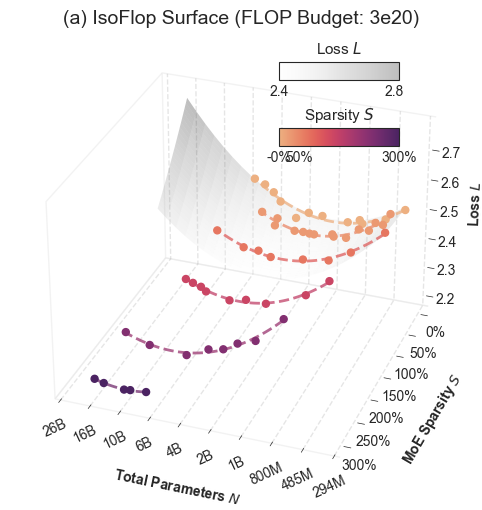

In [97]:
def get_individual_sparsity_fits(all_df, flops):
    """
    Get a fit for each sparsity level.
    """
    N, S, L = get_basic_data(all_df, flops)
    unique_sparsity = np.sort(np.unique(S))
    fits = []

    for sparsity in unique_sparsity:
        L_, N_, S_ = L[S==sparsity], N[S==sparsity], S[S==sparsity]
        out = fit_polynomial_model(N_, S_, L_, degree_N=2, degree_S=0, degree_NS=0, test_size=0.)
        out['input_data'] = (N_, S_, L_)
        out['sparsity_level'] = sparsity
        fits.append(out)

    return fits

def init_3d_plot(width=8, height=6):
    fig = plt.figure(figsize=(width, height))
    ax = fig.add_subplot(111, projection='3d')

    return fig, ax


def plot_scatter(all_df, flops, ax_3d, fig, marker_size=50, alpha=0.8, cmap='viridis', color_col='sparsity'):
    N, S, L = get_basic_data(all_df, flops)
    c = S if color_col == 'sparsity' else L
    scatter = ax_3d.scatter(N, S, L, c=c, cmap=cmap, s=marker_size, alpha=alpha, zorder=10)

    # "Despining" the 3D plot manually
    ax = ax_3d
    ax.set_facecolor('white')  # Set background color to white
    ax.grid(False)             # Remove the grid for minimalism
    # ax.xaxis.pane.set_edgecolor('white')  # Hide x-axis spine
    # ax.yaxis.pane.set_edgecolor('white')  # Hide y-axis spine
    # ax.zaxis.pane.set_edgecolor('white')  # Hide z-axis spine
    ax.xaxis.pane.fill = False  # Hide the x pane
    ax.yaxis.pane.fill = False  # Hide the y pane
    ax.zaxis.pane.fill = False  # Hide the z pane

    color = (0.9, 0.9, 0.9, 0.5)
    ax.xaxis.set_pane_color(color)  # RGB for light gray with full opacity
    ax.yaxis.set_pane_color(color)  # Adjust for y-axis pane
    ax.zaxis.set_pane_color(color)  # Adjust for z-axis pane

    # Optionally hide the axes lines
    ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))  # Hide the x-axis line
    ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))  # Hide the y-axis line
    ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))  # Hide the z-axis line

    # Handle x-ticks in normal scale (convert from log scale)
    xticks_log = ax.get_xticks()                    # Get current ticks in log scale
    xticks_normal = np.exp(xticks_log)              # Convert log scale ticks back to normal scale
    ax.set_xticks(xticks_log)                       # Set the same locations
    xticklabels = [utils_misc.make_number_human_readable(x, dp=0) for x in xticks_normal]
    ax.set_xticklabels(xticklabels, rotation=25)

    # Change sparsity labels
    ax.set_yticklabels([rf'{x*100:.0f}%' for x in ax.get_yticks()])

    ax.set_xlabel(r'Total Parameters $N$', fontweight='bold', labelpad=8, fontsize=label_fs)
    ax.set_ylabel(r'MoE Sparsity $S$', fontweight='bold', labelpad=8, fontsize=label_fs)
    ax.set_zlabel(r'Loss $L$', fontweight='bold', labelpad=0, fontsize=label_fs)

    # Adjust tick length, width, and padding
    ax.tick_params(axis='x', which='major', length=0.5, width=2, pad=0)  # Major ticks
    ax.tick_params(axis='y', which='major', length=0.5, width=2, pad=0)  # Major ticks
    ax.tick_params(axis='z', which='major', length=0.5, width=2, pad=0)  # Major ticks

    # change label size
    label_size = 10
    ax.xaxis.label.set_size(label_size)
    ax.yaxis.label.set_size(label_size)
    ax.zaxis.label.set_size(label_size)

    # cbar_ax = fig.add_axes([0.2, 0.65, 0.15, 0.03])  # [left, bottom, width, height]
    cbar_ax = fig.add_axes([0.56, 0.69, 0.15, 0.03])  # [left, bottom, width, height]

    colorbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')

    # Set only min and max labels for the colorbar
    colorbar.set_ticks([c.min(), 0.5, c.max()])
    colorbar.ax.tick_params(labelsize=10, length=0)

    if color_col == 'sparsity':
        percentages = [rf'{x*100:.0f}%' for x in colorbar.get_ticks()]
        colorbar.ax.set_xticklabels(percentages, fontsize=10)
        colorbar.ax.set_title(r'Sparsity $S$', fontsize=ticks_fs)
    else:
        colorbar.ax.set_xticklabels([f'{c.min():.1f}', f'{c.max():.1f}'], fontsize=10)
        colorbar.ax.set_title('Loss', fontsize=10)

def plot_sparsity_fit(all_df, flops, ax_3d, fig, cmap='viridis', alpha=0.75, lw=2):
    fits = get_individual_sparsity_fits(all_df, flops)
    color_map = plt.colormaps.get_cmap(cmap)
    num_fits = len(fits)

    for idx, fit in enumerate(fits):
        N_, S_, L_ = fit['input_data']
        model = fit['model']
        sparsity_level = fit['sparsity_level']

        # Generate grid
        N_range = np.linspace(N_.min(), N_.max(), 100)
        S_range = np.ones(100) * sparsity_level
        X_grid = generate_polynomial_matrix(N_range, S_range, degree_N=2, degree_S=0, degree_NS=0)
        L_range = model.predict(X_grid)

        color = color_map(idx / (num_fits ))  # Ensure distinct colors

        ax_3d.plot(N_range, S_range, L_range,
                   lw=lw, ls='--', alpha=alpha, color=color,
                   label=f'{sparsity_level * 100:.1f}% sparsity')

def plot_surface(all_df, flops, num_mesh_points, degree_N, degree_S, degree_NS, ax_3d, fig, **plot_kw):
    N, S, L = get_basic_data(all_df, flops)
    fit_info = fit_polynomial_model(N, S, L, degree_N=degree_N, degree_S=degree_S, degree_NS=degree_NS, test_size=0.)
    model = fit_info['model']

    # Generate grid
    N_range = np.linspace(N.min(), N.max(), num_mesh_points)
    S_range = np.linspace(S.min(), 0.999, num_mesh_points)
    N_grid, S_grid = np.meshgrid(N_range, S_range)
    N_grid_rs = N_grid.reshape(-1)
    S_grid_rs = S_grid.reshape(-1)
    X_poly_grid = generate_polynomial_matrix(N_grid_rs, S_grid_rs, degree_N=degree_N, degree_S=degree_S, degree_NS=degree_NS)

    L_fit_rs = model.predict(X_poly_grid)
    L_fit = L_fit_rs.reshape(num_mesh_points, num_mesh_points)

    # plot surface
    if ax_3d is not None:
        surface = ax_3d.plot_surface(N_grid, S_grid, L_fit, **plot_kw)
    
        # cbar_ax = fig.add_axes([0.58, 0.8, 0.15, 0.03])  # [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.56, 0.8, 0.15, 0.03])  # [left, bottom, width, height]
    
        colorbar = fig.colorbar(surface, cax=cbar_ax, orientation='horizontal')
        colorbar.set_ticks([L_fit.min(), L_fit.max()*.985])
        colorbar.ax.set_xticklabels([f'{L_fit.min():.1f}', f'{L_fit.max():.1f}'], fontsize=10)
        colorbar.ax.tick_params(labelsize=10, length=0)
        colorbar.ax.set_title(r'Loss $L$', fontsize=ticks_fs)

    return model

fig, ax = init_3d_plot(width=8, height=6)
model = plot_surface(df, FLOPS, 25, 2, 2, 2, ax, fig, cmap='Greys', alpha=.25, edgecolor='none')
plot_sparsity_fit(df, FLOPS, ax, fig, cmap='flare', alpha=0.75, lw=2)
plot_scatter(df, FLOPS, ax, fig, marker_size=25, alpha=1.0, cmap='flare')

ax.set_title(rf'(a) IsoFlop Surface (FLOP Budget: {FLOPS_STR})', fontsize=title_fs)

ax.grid(True)

ax.yaxis._axinfo['grid']['linewidth'] = 0
ax.zaxis._axinfo['grid']['linewidth'] = 0
ax.xaxis._axinfo["grid"]["linestyle"] = "--"      # Dotted line style
ax.xaxis._axinfo["grid"]["linewidth"] = 1       # Fine gridlines (adjust linewidth as needed)
ax.xaxis._axinfo["grid"]["color"] = (0.5, 0.5, 0.5, 0.2)  # Gray color with some transparency

# Adjust tick length, width, and padding
ax.tick_params(axis='x', which='major', length=0.5, width=2, pad=0)  # Major ticks
ax.tick_params(axis='y', which='major', length=0.5, width=2, pad=0)  # Major ticks
ax.tick_params(axis='z', which='major', length=0.5, width=0, pad=0)  # Major ticks

ax.view_init(elev=30, azim=110)

fig.savefig(NOTEBOOKS_DIR / 'plots' / 'a2.1_3d_plot.pdf', bbox_inches='tight', dpi=200, pad_inches=0.15)

In [98]:
# eval_df = get_test_dataframe(df, FLOPS, 100, 0.01, 'a2.1_test_data.csv')
# eval_df.head()

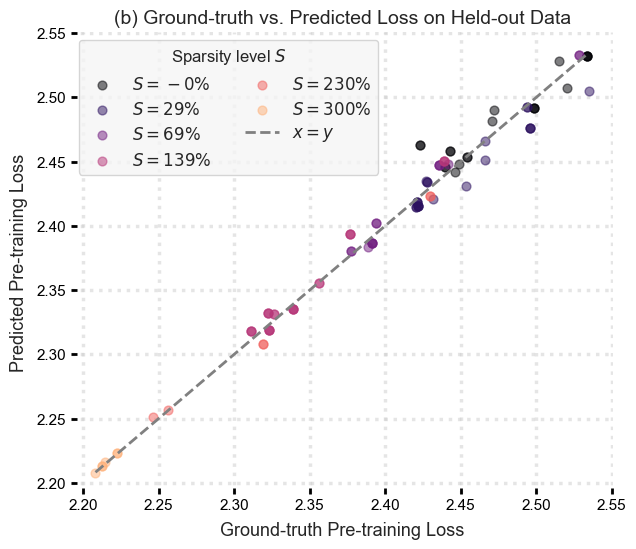

In [99]:
fig, ax = plt.subplots(1,1,figsize=(7,6))

sparsity_levels = np.sort(np.unique(eval_df['sparsity']))
cmap = plt.colormaps.get_cmap('magma')

for idx, sparsity_level in enumerate(sparsity_levels):
    df = eval_df[eval_df['sparsity'] == sparsity_level]
    label = rf'$S={sparsity_level*100:.0f}\%$'
    color = cmap(idx/len(sparsity_levels))
    ax.scatter(df['y'], df['yhat'], color=color, label=label, marker='o', s=40, alpha=0.5)

x_range = np.linspace(eval_df['y'].min(), eval_df['y'].max(), 25)
ax.plot(x_range, x_range, color='gray', ls='--', lw=2, label=r'$x=y$')

ax.set_title(r'(b) Ground-truth vs. Predicted Loss on Held-out Data', fontsize=title_fs)
ax.set_xlabel(r'Ground-truth Pre-training Loss', fontsize=label_fs, labelpad=6)
ax.set_ylabel(r'Predicted Pre-training Loss', fontsize=label_fs, labelpad=6)
ax.legend(loc='upper left', fontsize=legend_fs, ncol=2,
          title='Sparsity level $S$', title_fontsize=legend_fs,
          fancybox=True, facecolor='#F5F5F5')

sns.despine(ax=ax, offset=10, left=True, bottom=True)
ax.grid(True, ls=':', lw=2.5, alpha=0.5)
ax.set_axisbelow(True)

ax.tick_params(direction='in', length=4, width=2,
               colors='k', which='major', top=False,
               right=False, axis='both', labelsize=ticks_fs)

fig.savefig(NOTEBOOKS_DIR / 'plots' / 'a2.1_eval_plot.pdf',
            bbox_inches='tight', dpi=200, pad_inches=0.15)

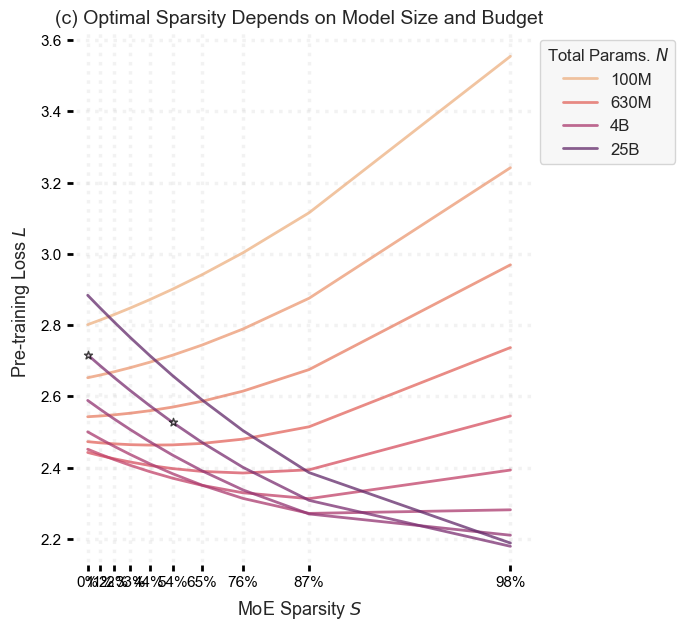

In [100]:
# fig, ax = plt.subplots(1,1,figsize=(7,6))
fig, ax = plt.subplots(1,1,figsize=(6,7))

cmap = plt.colormaps.get_cmap('flare')

min_model_size = 100e6
max_model_size = 25e9
num_models = 10

# model_sizes = np.linspace(min_model_size, max_model_size, num_models)
model_sizes = np.logspace(np.log(min_model_size), np.log(max_model_size), num_models, base=np.e)

num_sparsity_levels = 10
sparsity_levels = -np.log( 1 - np.linspace(0, 0.98, num_sparsity_levels))

best_size, best_loss = 0, np.inf
best_mdata = None

for idx, model_size in enumerate(model_sizes):
    N = np.ones_like(sparsity_levels) * np.log(model_size)
    S = sparsity_levels
    X = generate_polynomial_matrix(N, S, degree_N=2, degree_S=2, degree_NS=2)
    L = model.predict(X)

    

    ms = utils_misc.make_number_human_readable(model_size, dp=0)

    if np.min(L) < best_loss:
        best_size, best_loss = model_size, np.min(L)
        best_mdata = (sparsity_levels, L, idx, ms)

    label = rf'{ms}' if idx % 3 == 0 else None
    ax.plot(sparsity_levels, L, color=cmap(idx/len(model_sizes)),
             label=label, lw=2, alpha=0.75)

sparsity_levels, L, idx, ms = best_mdata
ax.scatter(sparsity_levels[::5], L[::5], color='k', facecolor='w',
           lw=1, alpha=0.75, marker='*', zorder=10)

# Update legend names
handles, labels = ax.get_legend_handles_labels()
for i, label in enumerate(labels):
    if ms==label:
        labels[i] = label.replace(ms, rf'{ms} ($\ast$)')

ax.set_title(r'(c) Optimal Sparsity Depends on Model Size and Budget', fontsize=title_fs)
ax.set_xlabel(r'MoE Sparsity $S$', fontsize=label_fs, labelpad=6)
ax.set_ylabel(r'Pre-training Loss $L$', fontsize=label_fs, labelpad=6)

ax.legend(handles, labels, fontsize=legend_fs, ncol=1,
          title='Total Params. $N$', title_fontsize=legend_fs,
          fancybox=True, facecolor='#F5F5F5', bbox_to_anchor=(1,1))

sns.despine(ax=ax, offset=1, left=True, bottom=True)
ax.grid(True, ls=':', lw=2.5, alpha=0.25)
ax.set_axisbelow(True)

ax.set_xticks(sparsity_levels)
ax.set_xticklabels([rf'{(1- np.exp(-x))*100:.0f}%' for x in ax.get_xticks()])
ax.tick_params(direction='in', length=4, width=2,
               colors='k', which='major', top=False,
               right=False, axis='both', labelsize=ticks_fs)

fig.savefig(NOTEBOOKS_DIR / 'plots' / 'a2.1_optimal_sparsity_plot.pdf',
            bbox_inches='tight', dpi=200, pad_inches=0)

In [101]:
def make_optimal_size_plot(ax, model, min_model_size=250e6, max_model_size=25e9, num_models=100, skip_every=3, marker=None, sparsity_levels=None):
    cmap = plt.colormaps.get_cmap(CMAP)
    model_sizes = np.logspace(np.log(min_model_size), np.log(max_model_size), num_models, base=np.e)

    if sparsity_levels is None:
        sparsity_levels = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

    for idx, sparsity_level in enumerate(sparsity_levels):
        N = np.log(model_sizes)
        S = np.ones_like(N) * sparsity_level
        S = LOG_TRANSFORM(S)
        X = generate_polynomial_matrix(N, S, degree_N=2, degree_S=2, degree_NS=2)
        L = model.predict(X)

        label = rf'{sparsity_level*100:.0f}%'
        if sparsity_level==sparsity_levels[-1]:
            label = rf'{label} ($\ast$)'

        label = label if idx % skip_every == 0 else None
        line, = ax.plot(N, L, color=cmap(idx/len(sparsity_levels)), label=label, lw=2, alpha=0.75)

        N_opt = (N[np.argsort(L)[0]])
        ax.plot([N_opt], [np.min(L)],
                marker='*', color='k', #line.get_color(),
                zorder=10, markersize=8, markerfacecolor='w', markeredgewidth=1)

    # Update legend names
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=legend_fs, ncol=4,
              title=r'MoE Sparsity $S$', title_fontsize=legend_fs,
              **legend_kw)

    xticks = ax.get_xticks()[1:-1]
    xticklabels = list(map(partial(utils_misc.make_number_human_readable, dp=0), np.exp(xticks)))
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

def make_optimal_sparsity_plot(ax, model, min_model_size=250e6, max_model_size=25e9, num_models=20, max_sparsity=0.99, num_sparsity_levels=100, skip_every=3, marker=None):
    model_sizes = np.logspace(np.log(min_model_size), np.log(max_model_size), num_models, base=np.e)
    sparsity_levels = np.linspace(0, max_sparsity, num_sparsity_levels)
    cmap = plt.colormaps.get_cmap(CMAP)

    best_loss, best_mdata = np.inf, None

    ns_opt = []

    for idx, model_size in enumerate(model_sizes):
        N = np.ones_like(sparsity_levels) * np.log(model_size)
        S = LOG_TRANSFORM(sparsity_levels)
        X = generate_polynomial_matrix(N, S, degree_N=2, degree_S=2, degree_NS=2)
        L = model.predict(X)
        
        if ax is not None:
            ms = utils_misc.make_number_human_readable(model_size)
            label = rf'{ms}' if idx % skip_every == 0 else None
            line = ax.plot(S, L, color=cmap(idx/len(model_sizes)),
                    label=label, lw=2, alpha=0.75, marker=marker)
        
        S_opt = (S[np.argsort(L)[1]])
        if np.argsort(L)[1] < (len(L) - 1) and np.argsort(L)[1] > 0:
            if ax is not None:
                ax.plot([S_opt], [np.min(L)],
                        marker='*', color=cmap(idx/len(model_sizes)),
                        zorder=10, markersize=8, markerfacecolor='w', markeredgewidth=1)
            ns_opt.append((model_size, S_opt))

    # Update legend names
    if ax is not None:
        handles, labels = ax.get_legend_handles_labels()
        for i, label in enumerate(labels):
            if ms==label:
                labels[i] = label.replace(ms, rf'{ms} ($\ast$)')
    
        ax.legend(handles, labels, fontsize=legend_fs, ncol=4,
                  title=r'Total Parameters $N$', title_fontsize=legend_fs+1,
                  **legend_kw)
    
        xticks_normal = INV_LOG_TRANSFORM(ax.get_xticks())
        xticklabels = [rf'{x*100:.0f}%' for x in xticks_normal]
        # ax.set_xticks(xticks_normal)
        ax.set_xticklabels(xticklabels)

    return ns_opt

In [102]:
def get_optimal_sparsity_given_model_size(model, model_sizes, min_sparsity=0, max_sparsity=0.9999, num_sparsity=2000):
    sparsities = np.linspace(0, max_sparsity, num_sparsity_levels)
    optimal_sparsity_levels = []
    optimal_model_sizes = []
    for model_size in model_sizes:
        S = LOG_TRANSFORM(sparsities)
        N = np.ones_like(S) * model_size
        N = np.log(N)
        X = generate_polynomial_matrix(N, S, degree_N=2, degree_S=2, degree_NS=2)
        L = model.predict(X)

        S_opt = (S[np.argsort(L)[1]])
        if np.argsort(L)[1] > 0 and np.argsort(L)[1] < (len(L) - 1):
            optimal_sparsity_levels.append(S_opt)
            optimal_model_sizes.append(N[np.argsort(L)[1]])

    return optimal_sparsity_levels, optimal_model_sizes
    

def plot_optimal_params(ax, optimal_map, is_loss=False, add_label_and_legend=False):

    cmap = plt.get_cmap(CMAP)
    num_flops = len(optimal_map)
    min_x, max_x = np.inf, -np.inf
    min_y, max_y = np.inf, -np.inf
    for i, (f, opt_vals) in enumerate(sorted(optimal_map.items(), key=lambda x: x[0])):
        label = str(f).replace('+', '') if add_label_and_legend else None
        opt_vals, x_values = opt_vals
        x = x_values
        min_x = min(min_x, np.min(x))
        max_x = max(max_x, np.max(x))
        min_y = min(min_y, np.min(opt_vals))
        max_y = max(max_y, np.max(opt_vals))
        ax.plot(x, opt_vals, label=label, c=cmap(i/num_flops), lw=2, ls='-',
                marker='o', markersize=2, markerfacecolor='w', markeredgewidth=1.5)

    # legend
    if add_label_and_legend:
        legend_kw['ncols'] = len(optimal_map)
        ax.legend(fontsize=legend_fs, title=r'Compute Budget $C$ (in FLOPs)', title_fontsize=legend_fs+1, **legend_kw)


    # ticks
    xticks = ax.get_xticks()
    min_x = np.round(min_x, 2)
    max_x = np.round(max_x, 2)
    xticks = np.array([x for x in xticks if min_x <= x <= max_x])
    # xticklabels = [f'{utils_misc.make_number_human_readable(_x)}' for _x in np.exp(xticks)]
    ax.set_xticks(xticks)
    # ax.set_xticklabels(xticklabels)

    yticks = ax.get_yticks()
    min_y = np.round(min_y, 2)  # Round down to 2 decimal places
    max_y = np.round(max_y, 2)   # Round up to 2 decimal places
    yticks = np.array([y for y in yticks if min_y <= y <= max_y])
    yticklabels = [f'{100*x:.0f}%' for x in INV_LOG_TRANSFORM(yticks)]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)



In [103]:
-np.log(1 - np.linspace(0, 1, 10))

/var/folders/j7/6f308lm15hq4fpwcb8pg59n00000gn/T/ipykernel_3497/3577084802.py:1: RuntimeWarning:

divide by zero encountered in log



array([-0.        ,  0.11778304,  0.25131443,  0.40546511,  0.58778666,
        0.81093022,  1.09861229,  1.5040774 ,  2.19722458,         inf])

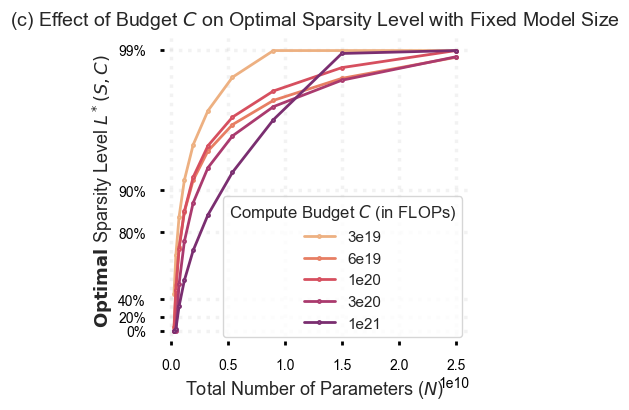

In [104]:
from functools import partial
plt.rcParams.update({
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': .5,
    'ytick.major.size': .5,
    'xtick.major.width': .5,
    'ytick.major.width': .5,
    'xtick.color': 'k',
    'ytick.color': 'k',
    'axes.edgecolor': 'black'
})

sns.set_style('ticks')

df = pd.read_csv('valid_wand_logs_latest')

df = df[~df['metadata.wandb_id'].isin(['k8iozpan'])]

df['ffn_target.granularity'] = df['ffn_target.granularity'].replace(np.nan, 1)
df['ffn_target.expansion_factor'] = df['ffn_target.expansion_factor'].fillna(df['ffn_target.num_experts'])
df['ffn_target.num_experts'] = df['ffn_target.num_experts'].fillna(df['ffn_target.expansion_factor'] * df['ffn_target.granularity'])
df['sparsity'] = - np.log(1 - (1.0 - (df['ffn_target.top_k'] / df['ffn_target.num_experts'])))

NOTEBOOKS_DIR = Path.cwd() / 'repos_xfs' / 'apple-moe' / 'notebooks'
FLOPS = 3e20
FLOPS_STR = '3e20'

title_fs = 14
label_fs = 13
legend_fs = 12
ticks_fs = 11

USE_LOG_S = True
LOG_TRANSFORM = lambda s: -np.log(1-s) if USE_LOG_S else s
INV_LOG_TRANSFORM = lambda s: 1-np.exp(-s) if USE_LOG_S else s

CMAP = 'flare'
FACECOLOR = '#F5F5F5'
legend_fs = 11
ylabelpad = 2
xlabelpad = 4
legend_bbox = (0.5, -0.3)
legend_kw = dict(borderpad=0.4, labelspacing=0.4, handletextpad=0.3, handlelength=1.2,fancybox=True,
                 facecolor=FACECOLOR, loc='center', bbox_to_anchor=legend_bbox, columnspacing=1.1)

def init_figure_v2(width, height, wspace=0.):
    from matplotlib.gridspec import GridSpec
    gs = GridSpec(1, 1, width_ratios=[1])  # Adjust width_ratios to control proportions
    fig = plt.figure(figsize=(width, height))
    ax1 = fig.add_subplot(gs[0])
    plt.subplots_adjust(wspace=wspace)
    return fig, ax1
    
fig, ax1= init_figure_v2(4, 4, wspace=0.14)

all_flops = df['flops.logged'].unique()
all_flops = sorted(list(np.float64(all_flops[all_flops < 3e21])))

ns_opt_dict = {}
flop_models = {}
min_x, max_x = np.inf, -np.inf
min_y, max_y = np.inf, -np.inf

for i, f in enumerate(all_flops):
    model = plot_surface(df, f, 1000, 2, 2, 2, None, fig, cmap='Greys', alpha=.25, edgecolor='none')
    ns_opt = make_optimal_sparsity_plot(None, model, min_model_size=250e6, max_model_size=25e9,
                               num_models=10, max_sparsity=0.99, num_sparsity_levels=10000, skip_every=3)
    ns_opt = np.asarray(ns_opt)
    flop_models[f] = model
    ns_opt_dict[f] = ns_opt

    min_x = min(min_x, np.min(x))
    max_x = max(max_x, np.max(x))
    min_y = min(min_y, np.min(opt_vals))
    max_y = max(max_y, np.max(opt_vals))

    label = str(f).replace('+', '')
    opt_vals = ns_opt[:, 1]
    x = ns_opt[:, 0]
    ax1.plot(x, opt_vals, label=label, c=cmap(i/len(all_flops)), lw=2, ls='-',
            marker='o', markersize=2, markerfacecolor='w', markeredgewidth=1.5)


ax1.legend(fontsize=legend_fs, title=r'Compute Budget $C$ (in FLOPs)', title_fontsize=legend_fs+1)
yticks = np.array([y for y in -np.log(1 - np.asarray([0.0, 0.2, 0.4, 0.8, 0.9, 0.99]))])
yticklabels = [f'{100*x:.0f}%' for x in INV_LOG_TRANSFORM(yticks)]
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticklabels)

title_y=1.01
ax1.set_title(r'(c) Effect of Budget $C$ on Optimal Sparsity Level with Fixed Model Size', fontsize=title_fs, y=title_y)
ax1.set_xlabel(r'Total Number of Parameters ($N$)', fontsize=label_fs, labelpad=xlabelpad)
ax1.set_ylabel(r'$\mathbf{Optimal}$ Sparsity Level $L^*(S, C)$', fontsize=label_fs, labelpad=ylabelpad)

ax1.grid(True, ls=':', lw=2.5, alpha=0.25)
ax1.set_axisbelow(True)
sns.despine(ax=ax1, offset=5, left=True, bottom=True)

ax1.tick_params(direction='in', length=3, width=2,
               colors='k', which='major', top=False,
               pad=10,
               right=False, axis='both', labelsize=ticks_fs-1)

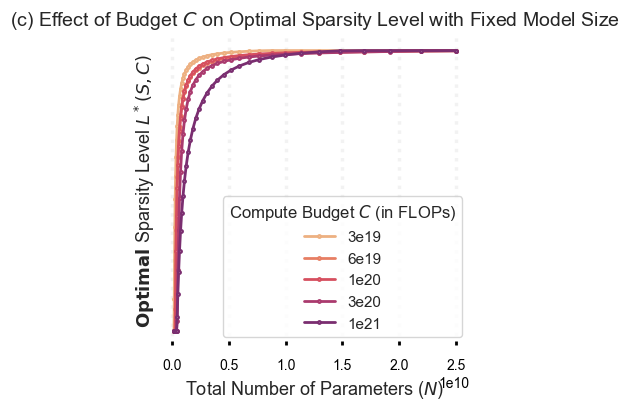

In [105]:
from functools import partial

df = pd.read_csv('valid_wand_logs_latest')

df = df[~df['metadata.wandb_id'].isin(['k8iozpan'])]

df['ffn_target.granularity'] = df['ffn_target.granularity'].replace(np.nan, 1)
df['ffn_target.expansion_factor'] = df['ffn_target.expansion_factor'].fillna(df['ffn_target.num_experts'])
df['ffn_target.num_experts'] = df['ffn_target.num_experts'].fillna(df['ffn_target.expansion_factor'] * df['ffn_target.granularity'])
df['sparsity'] = - np.log(1 - (1.0 - (df['ffn_target.top_k'] / df['ffn_target.num_experts'])))

# NOTEBOOKS_DIR = Path.cwd() / 'repos_xfs' / 'apple-moe' / 'notebooks'
FLOPS = 3e20
FLOPS_STR = '3e20'

title_fs = 14
label_fs = 13
legend_fs = 12
ticks_fs = 11

USE_LOG_S = True
LOG_TRANSFORM = lambda s: -np.log(1-s) if USE_LOG_S else s
INV_LOG_TRANSFORM = lambda s: 1-np.exp(-s) if USE_LOG_S else s

CMAP = 'flare'
FACECOLOR = '#F5F5F5'
legend_fs = 11
ylabelpad = 2
xlabelpad = 4
legend_bbox = (0.5, -0.3)
legend_kw = dict(borderpad=0.4, labelspacing=0.4, handletextpad=0.3, handlelength=1.2,fancybox=True,
                 facecolor=FACECOLOR, loc='center', bbox_to_anchor=legend_bbox, columnspacing=1.1)

def init_figure_v2(width, height, wspace=0.):
    from matplotlib.gridspec import GridSpec
    gs = GridSpec(1, 1, width_ratios=[1])  # Adjust width_ratios to control proportions
    fig = plt.figure(figsize=(width, height))
    ax1 = fig.add_subplot(gs[0])
    plt.subplots_adjust(wspace=wspace)
    return fig, ax1
    
fig, ax1= init_figure_v2(4, 4, wspace=0.14)

all_flops = df['flops.logged'].unique()
all_flops = sorted(list(np.float64(all_flops[all_flops < 3e21])))

ns_opt_dict = {}
flop_models = {}
min_x, max_x = np.inf, -np.inf
min_y, max_y = np.inf, -np.inf

for i, f in enumerate(all_flops):
    model = plot_surface(df, f, 1000, 2, 2, 2, None, fig, cmap='Greys', alpha=.25, edgecolor='none')
    ns_opt = make_optimal_sparsity_plot(None, model, min_model_size=150e6, max_model_size=25e9,
                               num_models=40, max_sparsity=0.99, num_sparsity_levels=10000, skip_every=3)
    ns_opt = np.asarray(ns_opt)
    flop_models[f] = model
    ns_opt_dict[f] = ns_opt
    label = str(f).replace('+', '')
    opt_vals = 1 - np.exp(-ns_opt[:, 1])
    
    min_x = min(min_x, np.min(x))
    max_x = max(max_x, np.max(x))
    min_y = min(min_y, np.min(opt_vals))
    max_y = max(max_y, np.max(opt_vals))


    x = ns_opt[:, 0]
    ax1.plot(x, opt_vals, label=label, c=cmap(i/len(all_flops)), lw=2, ls='-',
            marker='o', markersize=2, markerfacecolor='w', markeredgewidth=1.5)


ax1.legend(fontsize=legend_fs, title=r'Compute Budget $C$ (in FLOPs)', title_fontsize=legend_fs+1)
yticks = ax.get_yticks()
min_y = np.floor(min_y * 10) / 10  # Round down to 2 decimal places
max_y = np.ceil(max_y * 10) / 10   # Round up to 2 decimal places
yticks = np.array([y for y in yticks if min_y <= y <= max_y])
ax1.set_yticks(yticks)

title_y=1.01
ax1.set_title(r'(c) Effect of Budget $C$ on Optimal Sparsity Level with Fixed Model Size', fontsize=title_fs, y=title_y)
ax1.set_xlabel(r'Total Number of Parameters ($N$)', fontsize=label_fs, labelpad=xlabelpad)
ax1.set_ylabel(r'$\mathbf{Optimal}$ Sparsity Level $L^*(S, C)$', fontsize=label_fs, labelpad=ylabelpad)

ax1.grid(True, ls=':', lw=2.5, alpha=0.25)
ax1.set_axisbelow(True)
sns.despine(ax=ax1, offset=5, left=True, bottom=True)

ax1.tick_params(direction='in', length=3, width=2,
               colors='k', which='major', top=False,
               pad=10,
               right=False, axis='both', labelsize=ticks_fs-1)
